# PyTorch Implementation of SNGP

The core concepts of **Spectral-normalised Neural Gaussian Process** (SNGP) can be found in the original paper https://arxiv.org/abs/2006.10108. SNGP's main idea is to improve the ability of deep neural networks to retain distance information and to leverage this to determine the distance between test examples and the training data to improve predictive uncertainty estimates. 

This notebook roughly follows the outline of https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb but aims to implement all functionality shown here in PyTorch. https://github.com/alartum/sngp-pytorch is also an excellent implementation to consider and was read in determining how to organise my implementation.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from collections import namedtuple
NetResult = namedtuple('NetResult', ('mean', 'variance'))

Define visualization macros

In [ ]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the trainining and evaluation datasets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [ ]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [ ]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training.

In [ ]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

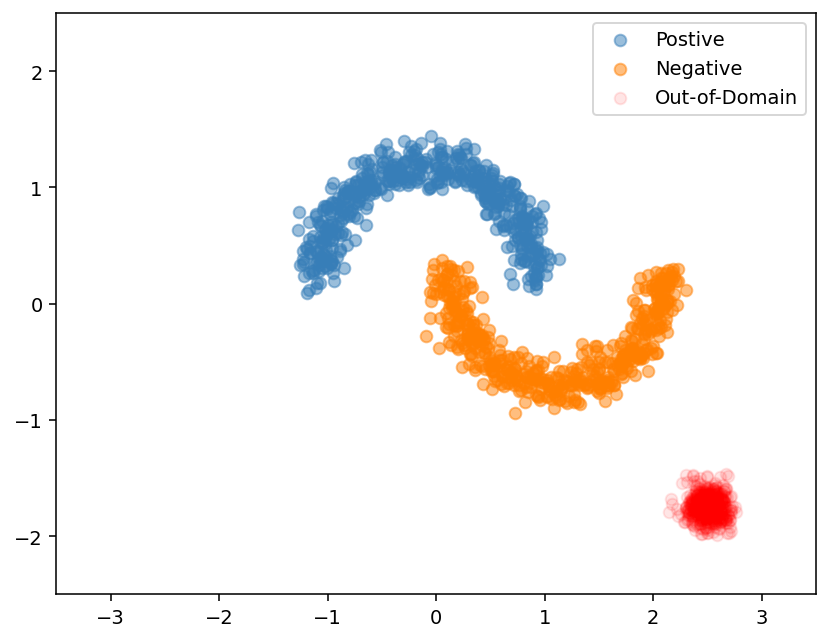

In [ ]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Here the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

In [ ]:
from torch.utils.data import Dataset, DataLoader
class TrainDataset(Dataset):
  def __init__(self, X, y, dtype_X = torch.FloatTensor, dtype_y = torch.LongTensor):
    self.train_examples = torch.from_numpy(X).type(dtype_X)
    self.train_labels = torch.from_numpy(y).type(dtype_y)

  def __len__(self):
    return len(self.train_examples)
  
  def __getitem__(self, idx):
    return self.train_examples[idx], self.train_labels[idx]

### Visualize uncertainty

The following code for plotting the classification and uncertainty surface can be found at https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb#scrollTo=HZDMX7gZrZ-5.

In [ ]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

In [ ]:
def plot_predictions(pred_probs, uncertainty, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

## The SNGP model

The SNGP model should preserve distance from the training data and we can leverage this for better predictive uncertainty estimation.

#### The ResNet Backbone
We define a basic neural network with skip connections below. Spectral normalisation is implemented in the spectral_norm_hook which is called after every backprop which updates the weights in a layer, and this enforces the spectral norm of the layer weights to be constrained. 

Applying spectral normalisation to a value below 1.0, due to the Lipschitz condition (this is described in the SNGP paper in detail), distance in the hidden layer representation of the input bears correspondence to distance in the data manifold, making it possible to use distance in the hidden representation to produce predictive certainty estimation.

In [ ]:
class ResNetBackbone(nn.Module):
  def __init__(self, 
               input_features: int = 2, 
               num_hidden_layers: int = 5, 
               num_hidden: int = 128, 
               dropout_rate: float = 0.1,
               norm_multiplier: float = 0.9):
    super().__init__()
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.input_layer = nn.Linear(in_features=input_features, out_features=num_hidden)
    self.hidden_layers = nn.Sequential(*[nn.Linear(in_features=num_hidden, out_features=num_hidden) for _ in range(num_hidden_layers)])
    self.norm_multiplier = norm_multiplier
    self.input_layer.register_full_backward_hook(self.spectral_norm_hook)
    for hidden_layer in self.hidden_layers:
      hidden_layer.register_full_backward_hook(self.spectral_norm_hook)

  def forward(self, input):
    input = self.input_layer(input)
    for hidden_layer in self.hidden_layers:
      residual = input
      input = F.dropout(F.relu(hidden_layer(input)), p=self.dropout_rate, training=self.training)
      input += residual
    return input
  
  def spectral_norm_hook(self, module, grad_input, grad_output):
    # applied to linear layer weights after gradient descent updates
    with torch.no_grad():
      norm = torch.linalg.matrix_norm(module.weight, 2)
      if self.norm_multiplier < norm:
        module.weight = nn.Parameter(self.norm_multiplier * module.weight / norm)

    

#### Gaussian Process Output Layer
As discussed in the SNGP paper, a Gaussian Process with a radial basis kernel is approximated using Random Fourier Features to approximate the prior distribution for the GP and then using the Laplace method to approximate the GP posterior. This yields a set of layers that are end to end trainable with the neural network backbone.

In [ ]:
import math
from torch.nn.parameter import Parameter

class RandomFeatureGaussianProcess(nn.Module):
    def __init__(
        self,
        out_features,
        backbone = ResNetBackbone(input_features=2, num_hidden_layers=5, num_hidden=128, dropout_rate=0.1),
        num_inducing = 1024,
        momentum = 0.9,
        ridge_penalty = 1e-6
    ):
        super().__init__()
        self.out_features = out_features
        self.num_inducing = num_inducing
        self.momentum = momentum
        self.ridge_penalty = ridge_penalty

        # Random Fourier features (RFF) layer
        random_fourier_feature_layer = nn.Linear(backbone.num_hidden, num_inducing)
        random_fourier_feature_layer.weight.requires_grad_(False)
        random_fourier_feature_layer.bias.requires_grad_(False)
        nn.init.normal_(random_fourier_feature_layer.weight, mean=0.0, std=1.0)
        nn.init.uniform_(random_fourier_feature_layer.bias, a=0.0, b=2 * math.pi)

        self.rff = nn.Sequential(backbone, random_fourier_feature_layer)
        
        # RFF approximation reduces the GP to a standard Bayesian linear model,
        # with beta being the parameters we wish to estimate by maximising
        # p(beta | D). To this end p(beta) (the prior) is gaussian so the loss
        # can be written as a standard MAP objective
        self.beta = nn.Linear(num_inducing, out_features, bias=False)
        nn.init.normal_(self.beta.weight, mean=0.0, std=1.0)

        # RFF precision and covariance matrices
        self.is_fitted = False
        self.covariance = Parameter(
            self.ridge_penalty * torch.eye(num_inducing),
            requires_grad=False,
        )

        self.precision_initial = self.ridge_penalty * torch.eye(
            num_inducing, requires_grad=False
        )
        self.precision = Parameter(
            self.precision_initial,
            requires_grad=False,
        )

    def forward(self, X, with_variance = False, update_precision = False):
        features = torch.cos(self.rff(X))
        if update_precision:
            self.update_precision_(features)

        logits = self.beta(features)
        if not with_variance:
            return NetResult(mean=logits,variance=None)
        else:
            if not self.is_fitted:
                raise ValueError(
                    "`compute_covariance` should be called before setting "
                    "`with_variance` to True"
                )
            with torch.no_grad():
                variances = torch.bmm(features[:, None, :], (features @ self.covariance)[:, :, None],).reshape(-1)

            return NetResult(logits, variances)

    def reset_precision(self):
        self.precision = self.precision_initial.detach()

    def update_precision_(self, features):
        # This assumes that all classes share a precision matrix like in 
        # https://www.tensorflow.org/tutorials/understanding/sngp

        # The original SNGP paper defines precision and covariance matrices on a
        # per class basis, however this can get expensive to compute with large
        # output spaces
        with torch.no_grad():
            if self.momentum < 0:
                self.precision = Parameter(self.precision + features.T @ features)
            else:
                self.precision = Parameter(self.momentum * self.precision + 
                (1 - self.momentum) * features.T @ features)
                

    def update_precision(self, X):
        with torch.no_grad():
            features = torch.cos(self.rff(X))
            self.update_precision_(features)

    def update_covariance(self):
        if not self.is_fitted:
            # The precision matrix is positive definite and so we can use its cholesky decomposition to more
            # efficiently compute its inverse
            self.covariance = Parameter(self.ridge_penalty * self.precision.cholesky_inverse())
            self.is_fitted = True

    def reset_covariance(self):
        self.is_fitted = False
        self.covariance.zero_()

In [ ]:
class Trainer:
  def __init__(self, 
               model_config, 
               task_type='classification',
               model=RandomFeatureGaussianProcess):
    self.model = model(**model_config)
    print(self.model)
    criterions = {
        'classification': nn.CrossEntropyLoss(reduction='mean'),
        'regression': nn.MSELoss(reduction='mean')
        }
    self.criterion = criterions[task_type]

  def train(self, training_data, data_loader_config, epochs=100, lr=1e-3):
    training_loader = DataLoader(training_data, **data_loader_config)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    mse = nn.MSELoss(reduction='mean')
    l2 = lambda betas: mse(betas, betas.new_zeros(betas.shape))
    
    def compute_loss(batch):
      X, y = batch
      logits, variance = self.model(X, with_variance=False, update_precision=True)

      neg_log_likelihood = self.criterion(logits, y)

      # RFF approximation reduced the GP problem to a Bayesian linear model
      # Since beta has gaussian prior, the objective can be written as a standard
      # MAP estimation as a regularised MLE objective
      
      betas = self.model.beta.weight
      l2_loss = 0.5 * l2(betas)

      # − log p(β|D) = − log p(D|β) + 0.5*||β||2
      neg_log_posterior = neg_log_likelihood + l2_loss
      return neg_log_posterior

    self.model.train(True)
    for epoch in range(epochs):
      running_loss = 0.
      for i, batch in enumerate(training_loader):
        self.model.reset_covariance()
        loss = compute_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      if epoch % 10 == 0:
        print(f'Avg Loss Epoch {epoch}: {running_loss/i}')
    self.model.train(False)
    return self.model


In [ ]:
sngp_config = dict(
        out_features=2,
        backbone = ResNetBackbone(input_features=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1),
        num_inducing = 1024,
        momentum = 0.9,
        ridge_penalty = 1e-6)
training_config = dict(batch_size=128, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='classification', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=TrainDataset(X=train_examples, y=train_labels), data_loader_config=training_config, epochs=100)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (hidden_layers): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): Linear(in_features=128, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=2, bias=False)
)
Avg Loss Epoch 0: 14.465519223894391
Avg Loss Epoch 10: 6.703057765960693
Avg Loss Epoch 20: 4.7432986327580045
Avg Loss Epoch 30: 4.602579968316214
Avg Loss Epoch 40: 3.5510354212352206
Avg Loss Epoch 50: 2.704124246324812
Avg Loss Epoch 60: 2.08428418636322
Avg Loss Epoch 

In [ ]:
def mean_field_logits(logits, variances, mean_field_factor):
  logits_scale = (1.0 + variances * mean_field_factor) ** 0.5
  if len(logits.shape) > 1:
    logits_scale = logits_scale[:, None]
  return logits/logits_scale

In [ ]:
test = torch.Tensor(test_examples)
test.shape

torch.Size([10000, 2])

In [ ]:
model.eval()
model.update_covariance()
logits, variances = model(test, with_variance=True, update_precision=False)
logits = mean_field_logits(logits, variances, np.pi/8.)
probs = logits.detach().softmax(dim=1).numpy()[:,0]
variances = variances.numpy()


#### Computing the posterior predictive probability
We could use Monte Carlo sampling but this requires multiple inferences and removes the latency benefits of SNGP over using ensembles or MC dropout to estimate predictive uncertainty. Instead, we approximate $E(p(x))$ using the mean-field method:

$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt(1 + \lambda \sigma^2(x))})$

where often $\lambda$ is chosen as $\pi/8$ or $3/\pi^2$.

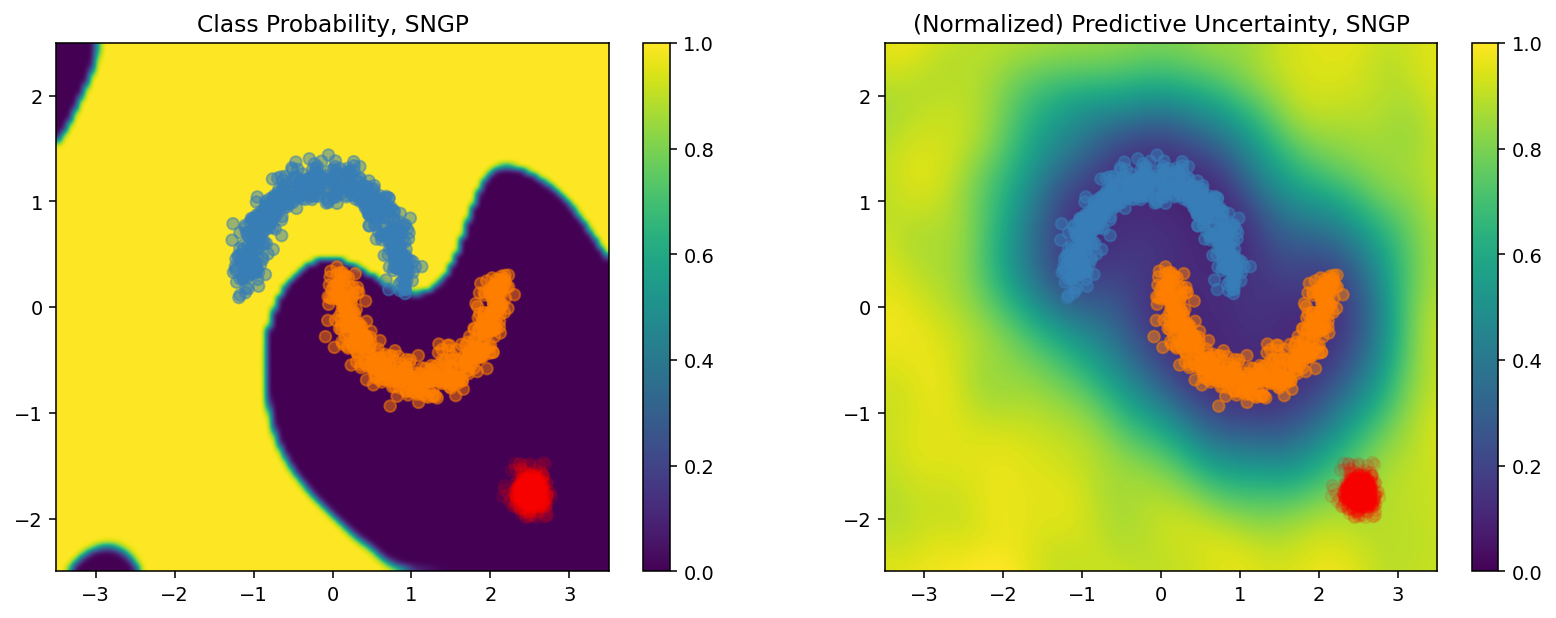

In [ ]:
plot_predictions(probs, variances, model_name="SNGP")


In [ ]:
# Verifying that spectral normalisation has been applied to backbone layer weights
print([torch.linalg.norm(hidden_layer.weight, 2) for hidden_layer in model.rff[0].hidden_layers])
print(torch.linalg.norm(model.rff[0].input_layer.weight, 2))

[tensor(0.9000, grad_fn=<CopyBackwards>), tensor(0.9000, grad_fn=<CopyBackwards>), tensor(0.9000, grad_fn=<CopyBackwards>), tensor(0.9000, grad_fn=<CopyBackwards>), tensor(0.9000, grad_fn=<CopyBackwards>), tensor(0.9000, grad_fn=<CopyBackwards>)]
tensor(0.9000, grad_fn=<CopyBackwards>)


# Regression
We adapt training of the SNGP for regression tasks by updating the loss function used. As the Laplace method approximates the RFF posterior using a Gaussian likelihood centered around a MAP estimate, and minimising the negative log likelihood can be done by minimising the mean squared error, we can plug in the mean square error loss for the cross entropy loss in the trainer.

In [ ]:
X = np.linspace(start=-10000, stop=10000, num=100000).reshape(-1, 1)
y = np.squeeze(X**3 + X - np.log(X**2))
y = (y - np.mean(y)) / np.std(y)

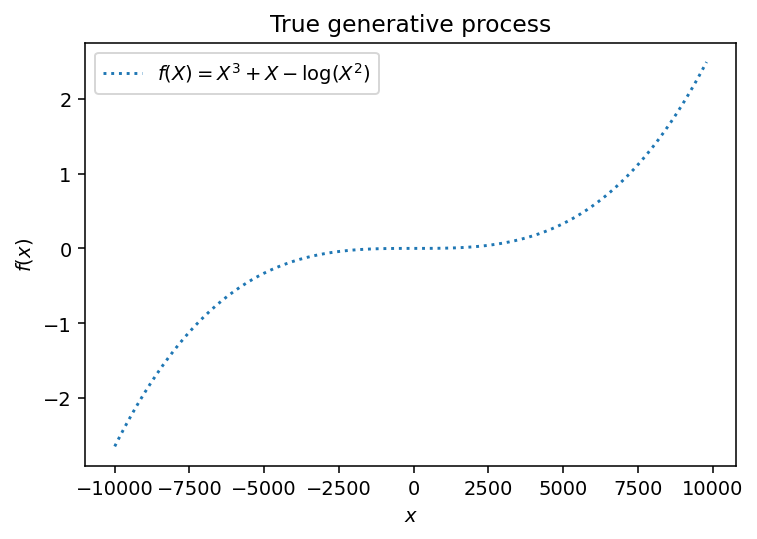

In [ ]:
plt.plot(X[::1000], y[::1000], label=r"$f(X) = X^3 + X - \log(X^2)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [ ]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size//4, y.size*3//4), size=4000, replace=False)
# training_indices = np.arange(y.size//4, y.size*3//4)[::5]
X_train, y_train = X[training_indices], y[training_indices]
noise_std = 0.01
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [ ]:
train_dataset = TrainDataset(X_train, np.expand_dims(y_train_noisy, axis=1), torch.FloatTensor, torch.FloatTensor)
len(train_dataset)

4000

In [ ]:
sngp_config = dict(
        out_features=1,
        backbone = ResNetBackbone(input_features=1, num_hidden_layers=0, num_hidden=64, dropout_rate=0.01, norm_multiplier=0.9),
        num_inducing = 1024,
        momentum = 0.9,
        ridge_penalty = 1e-6)
training_config = dict(batch_size=32, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='regression', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=train_dataset, data_loader_config=training_config, epochs=100, lr=1e-3)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=1, out_features=64, bias=True)
      (hidden_layers): Sequential()
    )
    (1): Linear(in_features=64, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=1, bias=False)
)
Avg Loss Epoch 0: 497.5607569294591
Avg Loss Epoch 10: 234.93622041517688
Avg Loss Epoch 20: 123.70258595866542
Avg Loss Epoch 30: 64.7704560987411
Avg Loss Epoch 40: 32.36990721764103
Avg Loss Epoch 50: 15.353237352063578
Avg Loss Epoch 60: 6.983142172136614
Avg Loss Epoch 70: 3.155864244507205
Avg Loss Epoch 80: 1.492385525376566
Avg Loss Epoch 90: 0.76978615623328


In [ ]:
test_dataset = torch.Tensor(X)

In [ ]:
model.eval()
model.update_covariance()
predictions, variances = model(test_dataset, with_variance=True, update_precision=False)
predictions = predictions.detach().numpy()
variances = variances.numpy()
variances = variances/np.max(variances)

In [ ]:
variances[::1000][:20]

array([0.8587706 , 0.9296182 , 0.849059  , 0.81022376, 0.8956073 ,
       0.86268175, 0.86647964, 0.9005295 , 0.9328133 , 0.9103223 ,
       0.84698534, 0.84553224, 0.84153116, 0.97233444, 0.8475482 ,
       0.88360167, 0.8458715 , 0.89453065, 0.84389603, 0.8363692 ],
      dtype=float32)

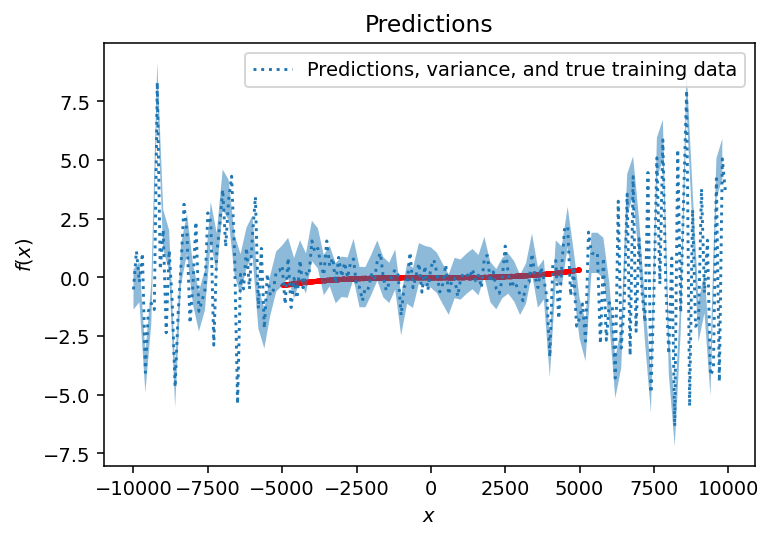

In [ ]:
plt.plot(X[::500], predictions[::500], label=r"Predictions, variance, and true training data", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, s=1, c='red')
plt.fill_between(X[::1000].transpose()[0], predictions[::1000].transpose()[0]-variances[::1000].transpose()[0], predictions[::1000].transpose()[0]+variances[::1000].transpose()[0], alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Predictions")

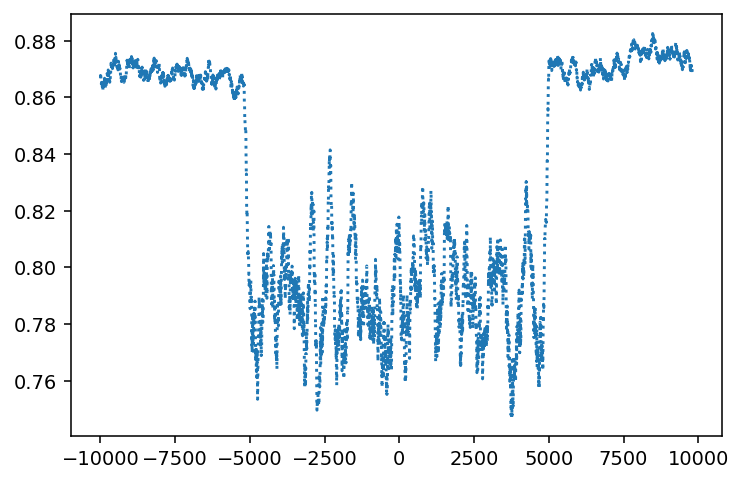

In [ ]:
plt.plot(X[::10][:-99], np.convolve(variances[::10], np.ones(100)/100, mode='valid'), linestyle='dotted')

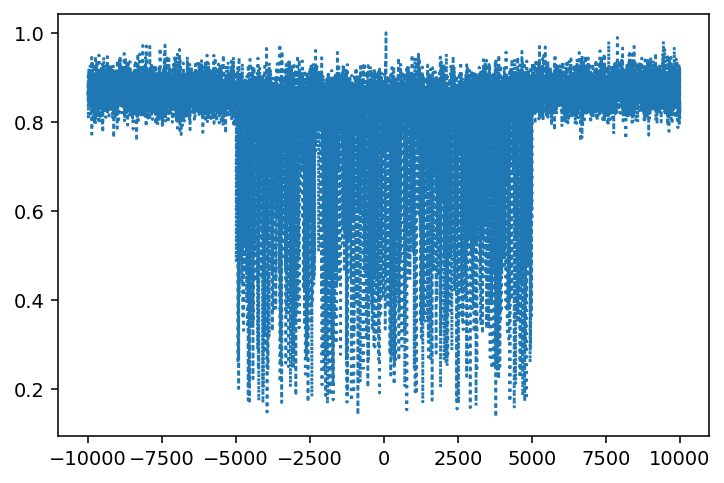

In [ ]:
plt.plot(X[::10], variances[::10], linestyle='dotted')

#### 2D Input Data
Here I will try and illustrate this distance related out of distribution uncertainty increase that is seen, but with a 2D input.

In [ ]:
def f(X, Y):
  return np.sin(X) + np.cos(Y)

def f1(xs):
  return xs[0] + np.sin(xs[1])

X1 = np.arange(-10, 10, 0.01)
Y1 = np.arange(-10, 10, 0.01)
X, Y = np.meshgrid(X1, Y1)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
Z = (Z-np.mean(Z, axis=1))/np.std(Z, axis=1)

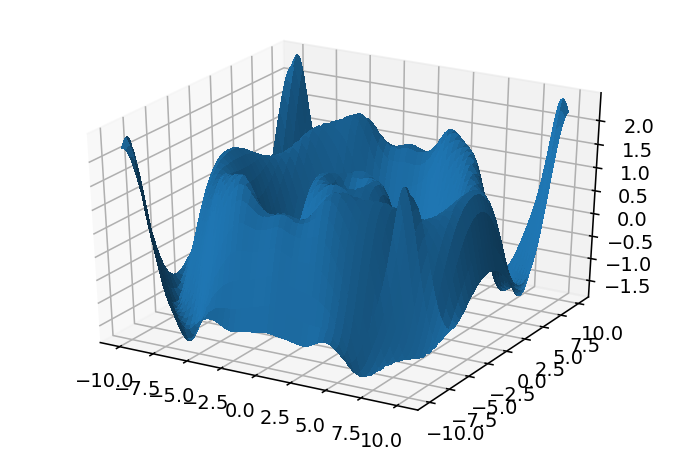

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)

In [ ]:
train_input = np.array([[x, y] for x in X1 for y in Y1])
train_input.shape

(4000000, 2)

In [ ]:
def f(input):
  x, y = input
  return np.sin(np.sqrt(x**2 + y**2))
train_labels = np.array([f(input) for input in train_input])
train_labels.shape

(4000000,)

In [ ]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(0, train_labels.shape[0]//2), size=80000, replace=False)
X_train, y_train = train_input[training_indices], train_labels[training_indices]
noise_std = 0.01
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [ ]:
train_dataset = TrainDataset(X_train, np.expand_dims(y_train_noisy, axis=1), torch.FloatTensor, torch.FloatTensor)
len(train_dataset)

80000

In [ ]:
sngp_config = dict(
        out_features=1,
        backbone = ResNetBackbone(input_features=2, num_hidden_layers=1, num_hidden=128, dropout_rate=0.01, norm_multiplier=0.9),
        num_inducing = 1024,
        momentum = 0.9,
        ridge_penalty = 1e-6)
training_config = dict(batch_size=64, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='regression', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=train_dataset, data_loader_config=training_config, epochs=50, lr=1e-3)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (hidden_layers): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): Linear(in_features=128, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=1, bias=False)
)
Avg Loss Epoch 0: 48.17020123209163
Avg Loss Epoch 10: 0.9704884030133653
Avg Loss Epoch 20: 0.19130435299644288
Avg Loss Epoch 30: 0.06148608447350055
Avg Loss Epoch 40: 0.016759371314886765


In [ ]:
test_dataset = torch.Tensor(train_input[::10])
len(test_dataset)

400000

In [ ]:
model.eval()
model.update_covariance()
predictions, variances = model(test_dataset, with_variance=True, update_precision=False)
predictions = predictions.detach().numpy()
variances = variances.numpy()
variances = variances/np.max(variances)

This plot illustrates model predictions after training

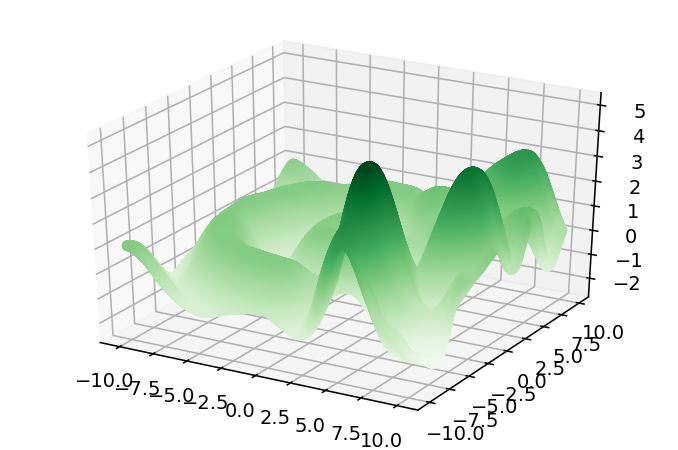

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter3D(train_input[:,0][::10], train_input[:,1][::10], predictions, c=predictions, cmap='Greens');


This plot illustrates the support of the training data (which is in one half of the input space)

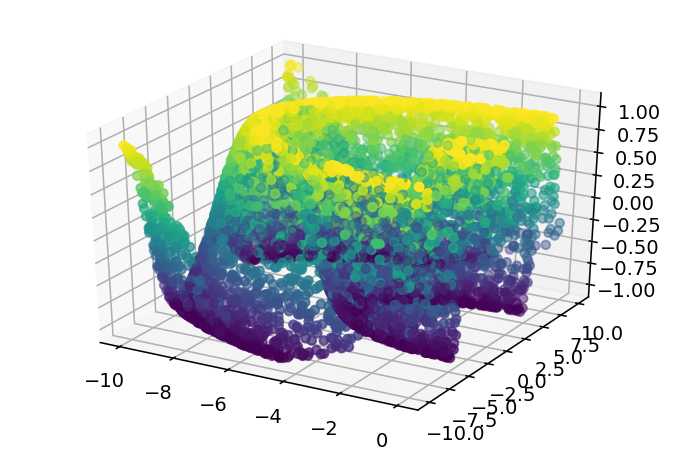

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter3D(X_train[:,0][::10], X_train[:,1][::10], y_train[::10], c=y_train[::10]);


This plot illustrates how uncertainty increases sharply as we move from in distribution to out of distribution data.

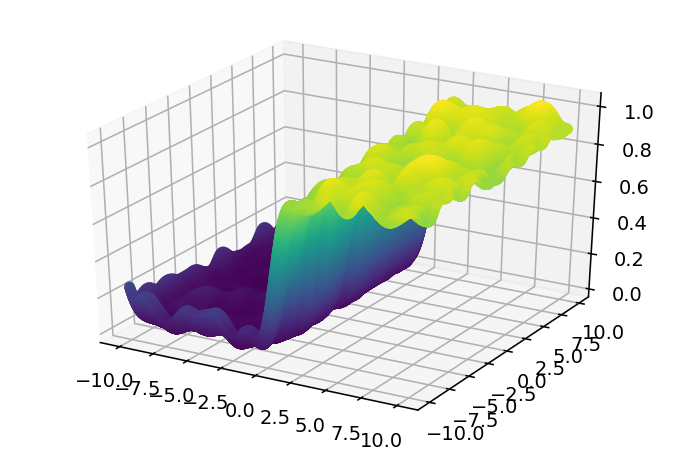

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter3D(train_input[:,0][::10], train_input[:,1][::10], variances, c=variances);
